In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd drive/MyDrive/Lit_S13/lightning_yolo/

In [4]:
#%pwd

In [7]:
#%ls

In [8]:
#!zip -r images.zip /content/drive/MyDrive/Lit_S13/lightning_yolo/PASCAL_VOC/images

In [1]:
import multiprocessing
pool = multiprocessing.Pool()
pool._processes

10

In [2]:
#%pip install watermark

In [3]:
from utils import get_loaders
import config
from models.model import YOLOv3
from models.lit_model import LightningYolo3
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning import Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner
import torch
from lit_dataset import PascalVOCDataModule

/Users/qureshsu/.local/share/virtualenvs/S6-JNyiktla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%load_ext watermark
%watermark
%watermark -v -p torch,lightning --conda

Last updated: 2023-08-25T20:13:43.469504+05:30

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : Clang 14.0.3 (clang-1403.0.22.14.1)
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

torch    : 2.0.1
lightning: 2.0.6

conda environment: base



In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
datamodule = PascalVOCDataModule(
    train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/test.csv"
)

In [15]:
print("Total Batches in Trainloader: ", len(datamodule.train_dataloader()))

num_epochs = 1

for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(datamodule.train_dataloader()):
        if batch_idx >=3:
            break
        print(" Batch Index:", batch_idx, end="")
        print(" | Batch Size: ", len(label) ," | Batch per scale ", label[0].shape[0], end="")
        print(" | Image Shape:", image.shape, end="")
        print(" | Label Shape:", label[0].shape)

Total Batches in Trainloader:  1035
 Batch Index: 0 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])
 Batch Index: 1 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])
 Batch Index: 2 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])


In [16]:
print("Total Batches in Trainloader: ", len(datamodule.val_dataloader()))

num_epochs = 1

for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(datamodule.val_dataloader()):
        if batch_idx >=3:
            break
        print(" Batch Index:", batch_idx, end="")
        print(" | Batch Size: ", len(label) ," | Batch per scale ", label[0].shape[0], end="")
        print(" | Image Shape:", image.shape, end="")
        print(" | Label Shape:", label[0].shape)

Total Batches in Trainloader:  310
 Batch Index: 0 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])
 Batch Index: 1 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])
 Batch Index: 2 | Batch Size:  3  | Batch per scale  16 | Image Shape: torch.Size([16, 3, 416, 416]) | Label Shape: torch.Size([16, 3, 13, 13, 6])


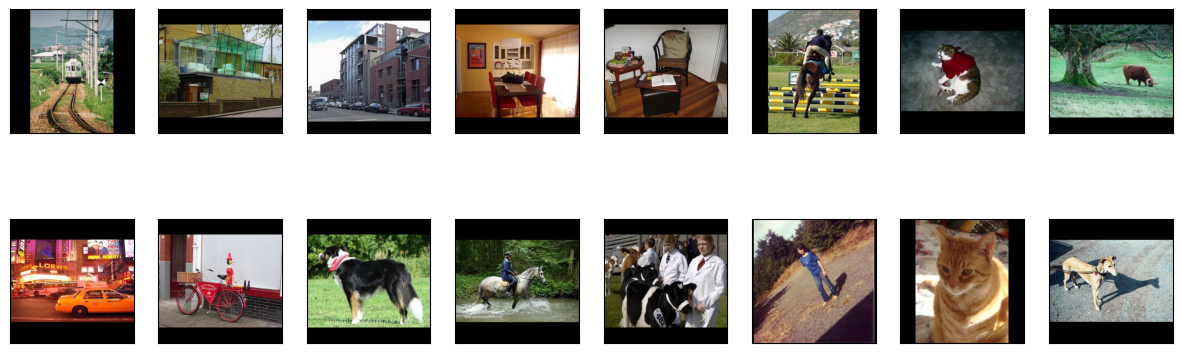

In [7]:
from visualise import print_samples
print_samples(datamodule.val_dataloader(), 16)

In [8]:
# For CosineAnnealing 1 cycle Scheduler
EPOCHS = config.NUM_EPOCHS * 2 // 5
num_steps = len(datamodule.train_dataloader())
#num_steps = len(train_loader)
num_steps

1035

In [9]:
num_classes = config.NUM_CLASSES
pytorch_model = YOLOv3(in_channels=3, num_classes=num_classes)
lightning_model = LightningYolo3(
    model=pytorch_model, learning_rate=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY,
    num_steps=num_steps, num_epochs=EPOCHS, max_lr=1E-3
    )

In [10]:
#lightning_model.to(device=config.DEVICE)

In [11]:
#lightning_model.device

In [10]:
checkpointing = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_loss", save_last=True)

In [11]:
# Create trainer
trainer = Trainer(
    #log_every_n_steps=1,
    precision=16,   # Precision means float16, float32, float8 etc.. i6 means float16. Reducing precision increases speed but reduces accuracy slightly
    accelerator="gpu",
    devices="auto",
    max_epochs=EPOCHS,
    logger = CSVLogger(save_dir="trained_model/", name="best_model"),
    callbacks= [checkpointing],
    default_root_dir=("trained_model/"),
    #fast_dev_run = True,
    #strategy="ddp_notebook",
)

#create tuner
tuner = Tuner(trainer)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Full training logs are not present as training was interrupted multiple times. This is the log of last interval.

INFO: Restoring states from the checkpoint path at trained_model/best_model/version_4/checkpoints/epoch=37-step=19684.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at trained_model/best_model/version_4/checkpoints/epoch=37-step=19684.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type     | Params
--------------------------------------
0 | model    | YOLOv3   | 61.6 M
1 | criteria | YoloLoss | 0     
--------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
246.506   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type     | Params
--------------------------------------
0 | model    | YOLOv3   | 61.6 M
1 | criteria | YoloLoss | 0     
--------------------------------------
61.6 M    Trainable params
0         Non-traina

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

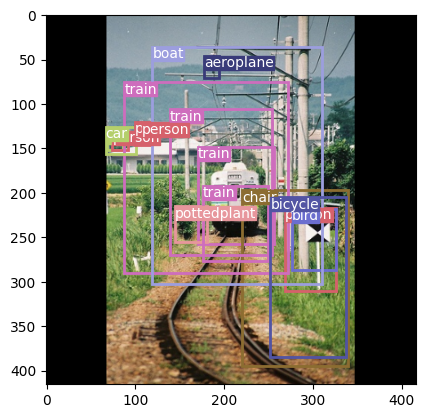

Validation: 0it [00:00, ?it/s]

Currently epoch 38


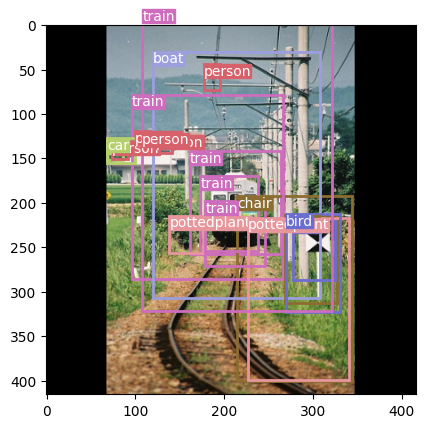

Validation: 0it [00:00, ?it/s]



  0%|          | 0/155 [00:00<?, ?it/s]

  1%|          | 1/155 [00:02<06:07,  2.39s/it]

  1%|▏         | 2/155 [00:02<03:11,  1.25s/it]

  2%|▏         | 3/155 [00:03<02:15,  1.12it/s]

  3%|▎         | 4/155 [00:03<01:49,  1.38it/s]

  3%|▎         | 5/155 [00:04<01:34,  1.58it/s]

  4%|▍         | 6/155 [00:04<01:28,  1.69it/s]

  5%|▍         | 7/155 [00:05<01:21,  1.82it/s]

  5%|▌         | 8/155 [00:05<01:16,  1.92it/s]

  6%|▌         | 9/155 [00:07<01:58,  1.23it/s]

  6%|▋         | 10/155 [00:07<01:43,  1.40it/s]

  7%|▋         | 11/155 [00:08<01:33,  1.54it/s]

  8%|▊         | 12/155 [00:08<01:25,  1.68it/s]

  8%|▊         | 13/155 [00:09<01:45,  1.34it/s]

  9%|▉         | 14/155 [00:10<01:33,  1.50it/s]

 10%|▉         | 15/155 [00:10<01:25,  1.63it/s]

 10%|█         | 16/155 [00:11<01:19,  1.75it/s]

 11%|█         | 17/155 [00:12<01:31,  1.51it/s]

 12%|█▏        | 18/155 [00:12<01:24,  1.62it/s]

 12%|█▏        | 19/155 [00:13<01:18,  1.74it/s]

 13%|█▎        |

Class accuracy is: 84.968140%
No obj accuracy is: 97.395798%
Obj accuracy is: 72.291496%




  0%|          | 0/155 [00:00<?, ?it/s]

  1%|          | 1/155 [00:12<32:11, 12.54s/it]

  1%|▏         | 2/155 [00:20<25:10,  9.87s/it]

  2%|▏         | 3/155 [00:29<24:27,  9.66s/it]

  3%|▎         | 4/155 [00:41<26:03, 10.35s/it]

  3%|▎         | 5/155 [00:47<22:17,  8.92s/it]

  4%|▍         | 6/155 [00:57<23:01,  9.27s/it]

  5%|▍         | 7/155 [01:03<20:26,  8.28s/it]

  5%|▌         | 8/155 [01:14<22:14,  9.08s/it]

  6%|▌         | 9/155 [01:23<21:48,  8.96s/it]

  6%|▋         | 10/155 [01:32<21:58,  9.09s/it]

  7%|▋         | 11/155 [01:38<19:00,  7.92s/it]

  8%|▊         | 12/155 [01:45<18:49,  7.90s/it]

  8%|▊         | 13/155 [01:56<20:15,  8.56s/it]

  9%|▉         | 14/155 [02:01<17:43,  7.54s/it]

 10%|▉         | 15/155 [02:10<18:29,  7.92s/it]

 10%|█         | 16/155 [02:14<16:10,  6.99s/it]

 11%|█         | 17/155 [02:26<19:21,  8.41s/it]

 12%|█▏        | 18/155 [02:31<17:09,  7.51s/it]

 12%|█▏        | 19/155 [02:42<18:50,  8.31s/it]

 13%|█▎        |

MAP: 0.3321639597415924
Currently epoch 39


INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [19]:
#trainer.fit(lightning_model, datamodule=datamodule)
trainer.fit(lightning_model, datamodule=datamodule,
            ckpt_path="trained_model/best_model/version_4/checkpoints/epoch=37-step=19684.ckpt")

# Inferencing / GradCAM

In [12]:
load_model = lightning_model.load_from_checkpoint(
    checkpoint_path="trained_model/best_model/version_0/checkpoints/epoch=39-step=20720.ckpt", map_location=torch.device("cpu"),
    model=pytorch_model, learning_rate=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY,
    num_steps=num_steps, num_epochs=EPOCHS, max_lr=1E-3
)
load_model.eval()

LightningYolo3(
  (model): YOLOv3(
    (layers): ModuleList(
      (0): CNNBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
      (1): CNNBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
      (2): ResidualBlock(
        (layers): ModuleList(
          (0): Sequential(
            (0): CNNBlock(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (leaky): LeakyReLU(negative_slope=0.1)
            )
            (1): CNNBlock(
              (conv): Co

In [65]:
# Mac is behaving unpredictable..... The same code in colab shows 2.9 loss on validation dataset
trainer.test(load_model, datamodule.val_dataloader())

Testing DataLoader 0: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     9.430788040161133     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 9.430788040161133}]

In [37]:
x, y = next(iter(datamodule.val_dataloader()))

In [30]:
scaled_anchors = (
            torch.tensor(config.ANCHORS)
            * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
        )#.to(config.DEVICE)
scaled_anchors

tensor([[[ 3.6400,  2.8600],
         [ 4.9400,  6.2400],
         [11.7000, 10.1400]],

        [[ 1.8200,  3.9000],
         [ 3.9000,  2.8600],
         [ 3.6400,  7.5400]],

        [[ 1.0400,  1.5600],
         [ 2.0800,  3.6400],
         [ 4.1600,  3.1200]]])

torch.Size([3, 416, 416]) (416, 416)


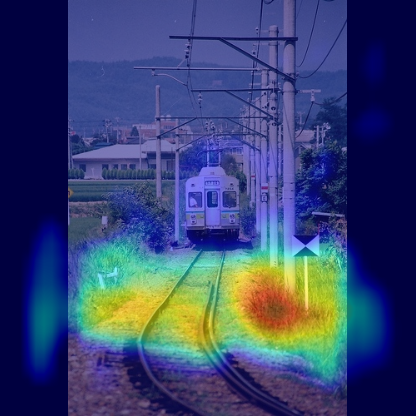

In [161]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from YOLOCAM import YoloCAM
from PIL import Image

tensor = x[0].unsqueeze(0)
#cam = YoloCAM(load_model, [load_model.model.layers[-1].pred[0].conv], use_cuda=False)
cam = YoloCAM(load_model, [load_model.model.layers[-3].layers[0][1].conv], use_cuda=False)
img = x[0].squeeze(0)# img = inv_normalize(img)
rgb_img = np.transpose(img, (1, 2, 0))
rgb_img = rgb_img.numpy()
grayscale_cam = cam(tensor, scaled_anchors)[0,:,:]

print(img.shape, grayscale_cam.shape)
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

## Some Test

In [164]:
#load_model.model.layers[-3].layers[0][1].conv
pytorch_model.layers[-3]

ResidualBlock(
  (layers): ModuleList(
    (0): Sequential(
      (0): CNNBlock(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
      (1): CNNBlock(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
    )
  )
)

In [74]:
out = load_model(x[3].unsqueeze(0))

In [116]:
from utils import non_max_suppression, plot_image
def plot_couple_examples(model, image, thresh, iou_thresh, anchors):
    model.eval()
    x = image.unsqueeze(0)
    #x = x.to(config.DEVICE)
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        #model.train()

        nms_boxes = non_max_suppression(
            bboxes[0], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        plot_image(x.squeeze(0).permute(1,2,0).detach().cpu(), nms_boxes)

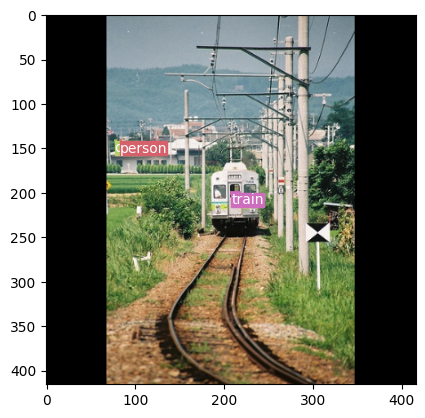

In [144]:
plot_couple_examples(load_model, x[0], 0.75, 0.5, anchors=scaled_anchors)